<a href="https://colab.research.google.com/github/sandoval19/Santander-challange/blob/master/Santander_CPT_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the packages 

In [0]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import warnings
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import backend as K
tf.enable_eager_execution()

Check if everything is okay

In [0]:
is_correct_tf_version = '1.14.' in tf.__version__
assert is_correct_tf_version, "Wrong tensorflow version {} installed".format(tf.__version__)

is_eager_enabled = tf.executing_eagerly()
assert is_eager_enabled,      "Tensorflow eager mode is not enabled"

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Análisis de los datos 

In [14]:
#Upload data from local 
from google.colab import files
train_data = files.upload()


Saving train.csv to train.csv


In [15]:
test_data = files.upload()

Saving test.csv to test.csv


In [20]:
import io 
train_dta=pd.read_csv(io.BytesIO(train_data['train.csv']))
test_dta=pd.read_csv(io.BytesIO(test_data['test.csv']))

print(train_dta.head())
print(test_dta.head())
print("dimensiones del train set:{}, test set:{}".format(train_dta.shape,test_dta.shape))

   ID_code  target    var_0   var_1  ...  var_196  var_197  var_198  var_199
0  train_0       0   8.9255 -6.7863  ...   7.8784   8.5635  12.7803  -1.0914
1  train_1       0  11.5006 -4.1473  ...   8.1267   8.7889  18.3560   1.9518
2  train_2       0   8.6093 -2.7457  ...  -6.5213   8.2675  14.7222   0.3965
3  train_3       0  11.0604 -2.1518  ...  -2.9275  10.2922  17.9697  -8.9996
4  train_4       0   9.8369 -1.4834  ...   3.9267   9.5031  17.9974  -8.8104

[5 rows x 202 columns]
  ID_code    var_0    var_1    var_2  ...  var_196  var_197  var_198  var_199
0  test_0  11.0656   7.7798  12.9536  ...   4.3654  10.7200  15.4722  -8.7197
1  test_1   8.5304   1.2543  11.3047  ...  -1.4852   9.8714  19.1293 -20.9760
2  test_2   5.4827 -10.3581  10.1407  ...  -7.1086   7.0618  19.8956 -23.1794
3  test_3   8.5374  -1.3222  12.0220  ...   3.9567   9.2295  13.0168  -4.2108
4  test_4  11.7058  -0.1327  14.1295  ...  -5.1612   7.2882  13.9260  -9.1846

[5 rows x 201 columns]
dimensiones del train 

In [21]:
def missing_data(data):
	"""
	Analyze the data, which its type is dataFrame to look for missing total values
	input: dataFrame 
	output: if not: Boolean, if there is missing data: dataFrame with missing values per colums
	"""
	flag = data.isna().sum().any()
	if flag:
		null_data=data.isnull().sum()
		percent= (null_data/data.isnull().count())*100

		#new data frame to return 
		mis_data= pd.concat([null_data,percent],axis=1,keys=['Total','Percent'])
		columns_type=[]
		for col in data.columns:
			dtype= str(data[col].dtype)
			columns_type.append(dtype)
		mis_data['Type'] = columns_type
		return (np.transpose(mis_data))
	else:
		return(False)

df_count_train=(missing_data(train_dta))
print(df_count_train)
df_count_test=(missing_data(test_dta))
print(df_count_test)

False
False


The data set doesn't have missing values

Now we describe some statistical values from train and test sets

In [22]:
train_stats = train_dta.describe()
print(train_stats)
test_stats = test_dta.describe()
print(test_stats)

              target          var_0  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean        0.100490      10.679914  ...      15.870720      -3.326537
std         0.300653       3.040051  ...       3.010945      10.438015
min         0.000000       0.408400  ...       6.299300     -38.852800
25%         0.000000       8.453850  ...      13.829700     -11.208475
50%         0.000000      10.524750  ...      15.934050      -2.819550
75%         0.000000      12.758200  ...      18.064725       4.836800
max         1.000000      20.315000  ...      26.079100      28.500700

[8 rows x 201 columns]
               var_0          var_1  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean       10.658737      -1.624244  ...      15.869184      -3.246342
std         3.036716       4.040509  ...       3.008717      10.398589
min         0.188700     -15.043400  ...       6.5840

**Analizing the std and mean values it is possible to conclude that the features are not normalized.**

**Also it is not scaled due to the Min-Max values gap.
It is possible to appply both scale and normalization**

Display the number of examples per class.

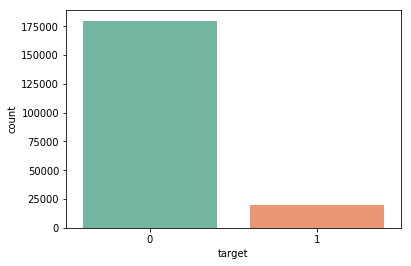

0    179902
1     20098
Name: target, dtype: int64
There are 10.049% target values with 1


In [23]:
sns.countplot(train_dta['target'],palette='Set2')
plt.show()

#pandas acomoda de manera descendente la predominancia
print( train_dta["target"].value_counts())
print("There are {}% target values with 1".format(100 * train_dta["target"].value_counts()[1]/train_dta.shape[0]))

Because of the data is unbalanced, it is necessary to sample the data in order to obtain a better balance btw the classes.

Shape of Clase One's (20098, 202)
Shape (26985, 202) of Clase Zero's with: 0.15 '%' of the original set
Shape of the new data sampled: (47083, 202)
Shape of the new test_data:  (47083, 201)
             ID_code  target   var_0  ...  var_197  var_198  var_199
25816    train_25816       0  7.5075  ...   8.4856  18.7919 -16.9808
151264  train_151264       1  6.9757  ...   9.6302  13.8950   8.1822
143764  train_143764       0  7.5550  ...   9.2998  10.4043   5.9086
129507  train_129507       1  9.5127  ...   8.5882  14.1588 -16.0273
88557    train_88557       0  6.7078  ...   9.1416  16.9159 -18.4228

[5 rows x 202 columns]
             ID_code  target    var_0  ...  var_197  var_198  var_199
27701    train_27701       0   9.8345  ...   7.7134  13.0270   6.6789
197178  train_197178       1  13.3921  ...   9.4910  14.1116  -6.3420
51384    train_51384       1   7.0229  ...   8.5599  15.1179  -4.2082
107408  train_107408       0  13.7906  ...   8.0839  19.0750 -17.6479
133839  train_133839  

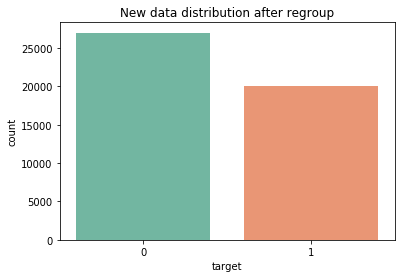

0    26985
1    20098
Name: target, dtype: int64
There are 42.68631990314976% target values with 1


In [24]:
df_ones = train_dta[train_dta['target'] > 0]
print("Shape of Clase One's",df_ones.shape)
#se toman un 15% de la clase 1 
fracc=0.15
df_zeros = train_dta[train_dta['target'] == 0].sample(frac=fracc)
print("Shape {} of Clase Zero's with: {} '%' of the original set".format(df_zeros.shape,fracc))
#we concat both to the sampling dataframe
#if frac is used with value 1 it will return all the data but shuffled
train_dta = pd.concat([df_ones, df_zeros]).sample(frac=1) #shuffling
test_dta= test_dta.sample(n=train_dta.shape[0])
print("Shape of the new data sampled:",train_dta.shape)
print("Shape of the new test_data: ", test_dta.shape)
print(train_dta.head())
print(train_dta.tail())

sns.countplot(train_dta['target'],palette='Set2')
plt.title('New data distribution after regroup')
plt.show()
print( train_dta["target"].value_counts())

print("There are {}% target values with 1".format(100 * train_dta["target"].value_counts()[1]/train_dta.shape[0]))


Here we look at the normal distribution of the features for both classes

In [0]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    """
    Grafica la probabilidad de la funcion de densidad (PDF) para ambos dataframes 
    basado en que las features estan en ambos dataframes y las etiqueta dependiendo del label
    input: dataframe1, dataframe2, string:label 1, string:label 2,lista/serie:features
    output: Nan
    """
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(22,22))
    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

100


<Figure size 432x288 with 0 Axes>

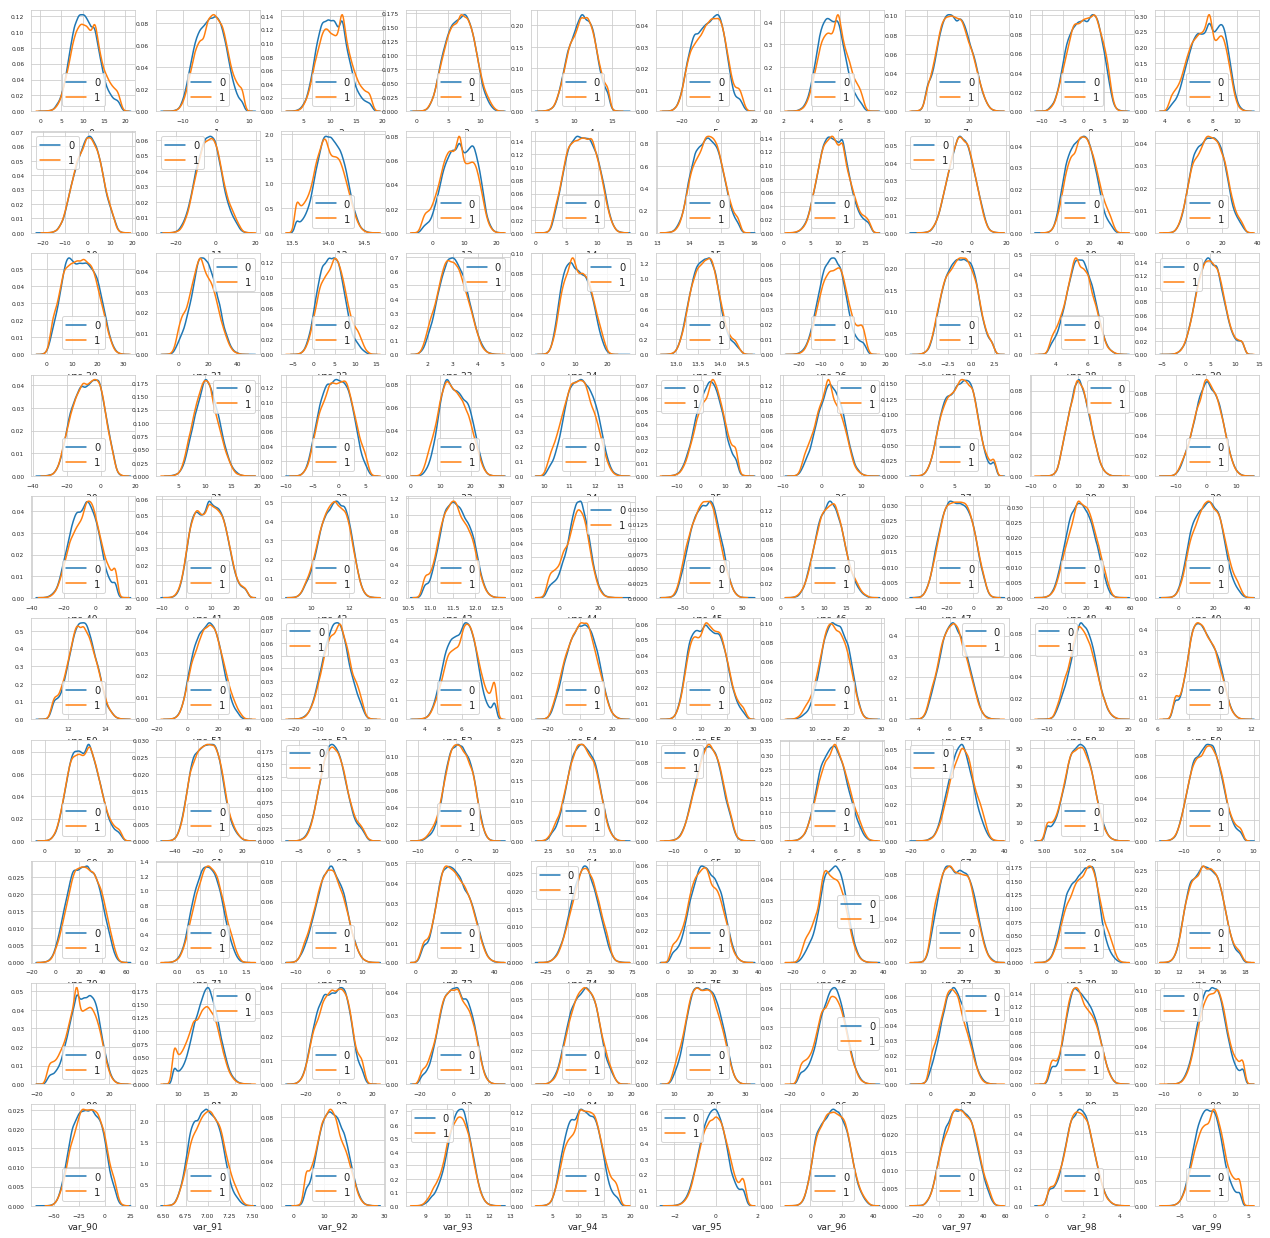

<Figure size 432x288 with 0 Axes>

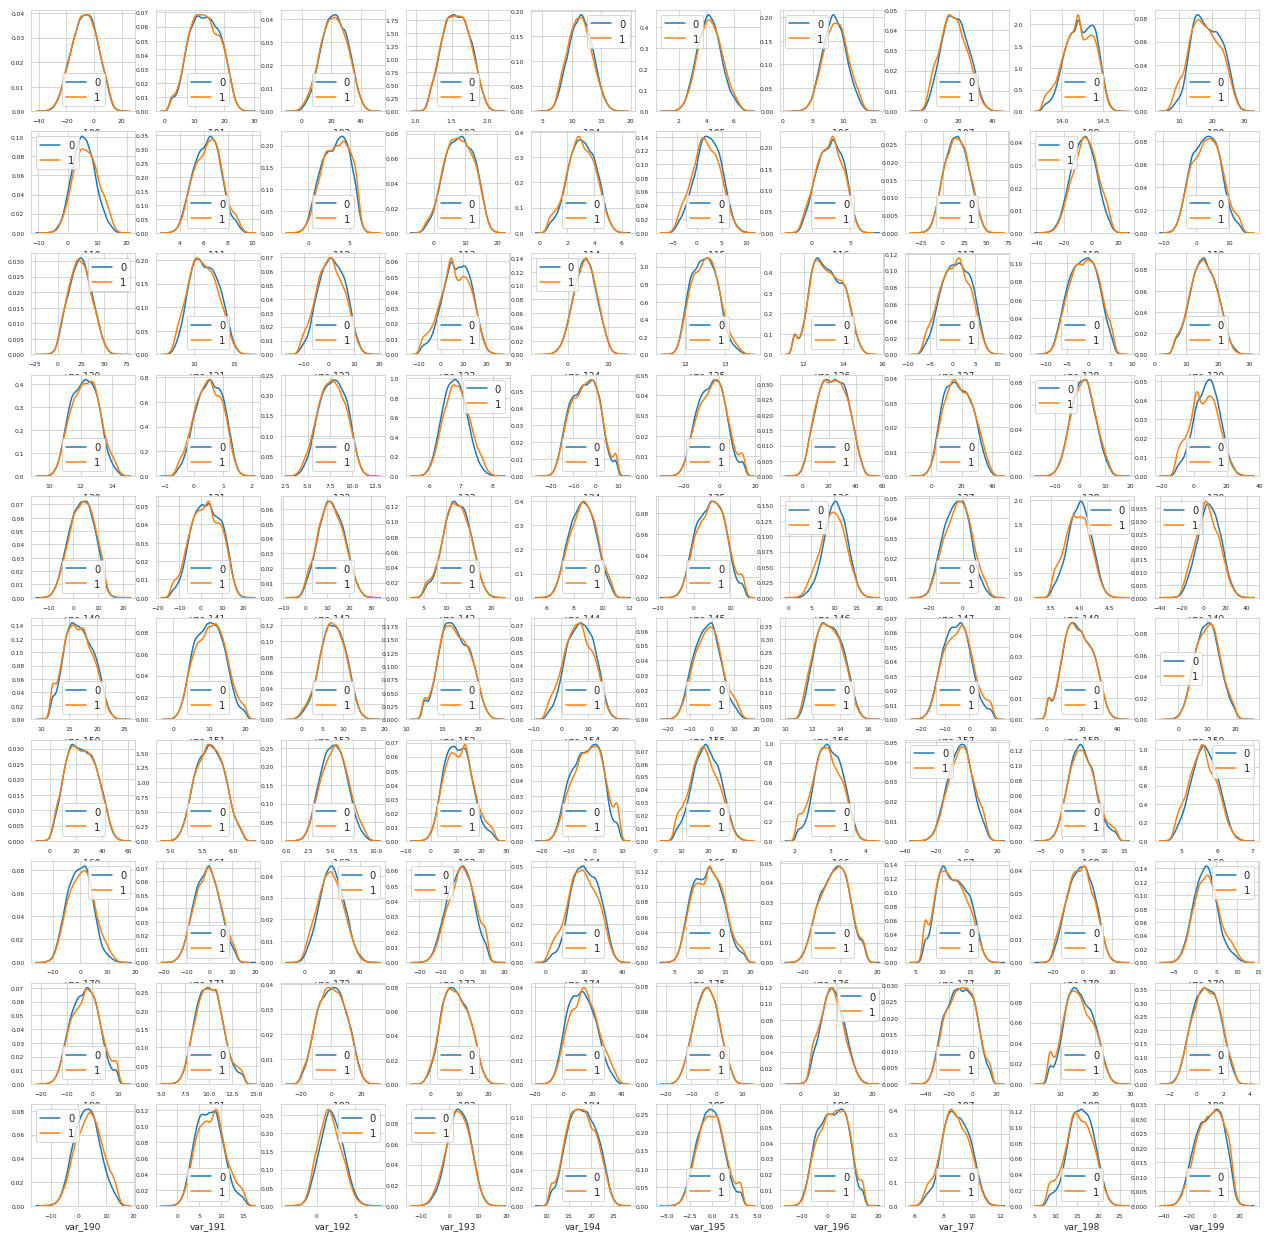

In [26]:
#primeros 100 features
t0 = train_dta.loc[train_dta['target'] == 0]
t1 = train_dta.loc[train_dta['target'] == 1]
features1 = train_dta.columns.values[2:102]
print(len(features1))
plot_feature_distribution(t0, t1, '0', '1', features1)
#los 100 features restantes
features2 = train_dta.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features2)

**The figure above helps to analize the correlation btw the features for both classes. Ex. if a PDF's feature is too much different in class 1 compared to 0, this feature will contribute to difference btw the classes.
Also if a PDF's feature is similar in both classes it probably will not contribute too much.**

Here we look at the normal distribution of the features for train set and test set

In [27]:
plot_feature_distribution(train_dta,test_dta,'train','test',features1)
plot_feature_distribution(train_dta,test_dta,'train','test',features2)

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: ignored

**The differences btw the features for both train and test are a criteria for feature selection.
Ex. if the features are different, the model maybe fall in miss classify that one because the model learned a different behavior for that feature.**

Here we look at the normal distribution of the features per example in both test and train sets.


In [0]:
features_tot = train_dta.columns.values[2:202]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_dta[features_tot].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_dta[features_tot].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

**It is possible to conclude that the examples remain a similar  distribution in train and test. So  those can be used to test the model once it learned the train set. 
tail examples may lead to bad classify.**

Here we look at the normal distribution of the features based on the min-max values per class.

Analizar la distribución de valores por feature para las clases 0 y 1

In [0]:
t0 = train_dta.loc[train_dta['target'] == 0]
t1 = train_dta.loc[train_dta['target'] == 1]

def plot_max_min_colum(dtf1,dtf2,label1,label2,features):

    plt.figure(figsize=(16,6))
    plt.subplot(2,1,1)
    plt.title("Distribution of min values per column in the train set")
    sns.distplot(dtf1[features].min(axis=0),color="orange", kde=True,bins=120, label='target = '+str(label1))
    sns.distplot(dtf2[features].min(axis=0),color="darkblue", kde=True,bins=120, label='target = '+str(label2))
    plt.legend()


    plt.subplot(2,1,2)
    plt.title("Distribution of max values per column in the train set")
    sns.distplot(dtf1[features].max(axis=0),color="red", kde=True,bins=120, label='target = '+str(label1))
    sns.distplot(dtf2[features].max(axis=0),color="blue", kde=True,bins=120, label='target = '+str(label2))
    plt.legend()
    plt.show()
plot_max_min_colum(t0,t1,'1','0',features_tot)

**Looking at the graph above, it is clear that normalization is necessary**

Droppped repeated examples, so the model will not be baised. 

In [0]:
train_data=train_dta.drop_duplicates(keep='first')
print(train_dta.shape)

**The data has no repeated values**

**Finally, the data for test and train displeyd a similar distribution for almost all the features, it was not necessary to delete features. However this idea may improve time running. Also after balance the data normalization will be  perform.**

#Featuring engineering 

Once the process of analyze the data was performed, featuring engineering will be apply in order to capture important info of both classes


First, we split the data train into X and labels Y. Also, the train data will be split into cross validation and train.

In [0]:
X=train_data.iloc[:,2:]
Y=train_data['target']
x_test=test_data.iloc[:,1:]
print("x_train")
print(X.head())
print("Shape new X train:", X.shape)
print("y_train")
print(Y.head())
print(Y.shape)
print("test_data")
print(x_test.head())
print("Shape new X test:",x_test.shape)

Now we add to the data the statistical values based on the examples (rows), such as mean, std, max, min, med. This features will allow the model to learn new info in order to predict for the classes.

In [0]:
idx = train_data.columns.values[2:202]
for df in [X, x_test]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['med'] = df[idx].median(axis=1)

Now, we normalize the data per column, with std 1 and mean 0



In [0]:
def norm(x):
    """
    Normalize the data
    input dataframe
    output dataframe normalized
    """
    #Following the formula 
    # z =  x - U / g 
    stats=x.describe()
    stats=stats.transpose()
    return (x - stats['mean'])/stats['std']

In [0]:
train_data=norm(train_data)
test_data=norm(test_data)

In [0]:
X=norm(X)
x_test=norm(x_test)
#X.to_pickle("x_train_normalized.pkl")
#Y.to_pickle("y_train_normalized.pkl")
#x_test.to_pickle("x_test_normalized.pkl")

#Modelo DNN

Una vez al tener el dataset necesario se genera el modelo con el cual se clasificará el usuario bajo la etiqueta de 0(realiza la transaacción) y 1(no realizá la transacción)

In [0]:
#x_train=pd.read_pickle('x_train_normalized.pkl')
#y_train=pd.read_pickle('y_train_normalized.pkl')
#x_predic=pd.read_pickle('x_test_normalized.pkl')
tst_size=0.3
x_train=X.copy()
y_train=Y.copy()
x_predic=x_test.copy()


Se dividio en dataset en entrenamiento y prueba. Posteriormente se divide el entrenamiento en una fracción de 0.2 para validación cruzada.
Quedando finalmente:


> entrenamiento pasa de 32958 a 26366

> validación cruzada  6592

> prueba 14125


In [0]:
#test train split

X_train, X_test, Y_train, y_test = train_test_split(x_train, y_train, test_size=tst_size, random_state=6666)
print("X_train: ", X_train.shape)
#print((X_train.head()))
print("X_test: " ,X_test.shape)
#print(X_test.head())
print("Y_train: ",Y_train.shape)
#print((Y_train.head()))

Se crean tres modelos diferentes, variando la funcion de optimización, el numero de capas ocultas y las funciones de activación según criterio de diseño. Adicionalmente para el primer modelo se utilizan regulaziración por L2

In [0]:
def buil_model(option=1,layer_size=100,hidden_units=3):
	"""
	create a DNN model
	input option to select different models, # hidden neurons,  # hidenn units
	ouput DNN model 
	"""
	if option == 1:
		model = keras.Sequential()
		model.add(layers.Dense(200,input_shape=(X_train.shape[1],),kernel_regularizer=keras.regularizers.l2(0.005)))
		model.add(layers.Activation('relu'))
		model.add(layers.Dropout(0.3))		
		
		model.add(layers.Dense(200,kernel_regularizer=keras.regularizers.l2(0.005)))
		model.add(layers.Activation('relu'))
		model.add(layers.Dropout(0.2))
		

		model.add(layers.Dense(150,kernel_regularizer=keras.regularizers.l2(0.005)))
		model.add(layers.Activation('relu'))
		model.add(layers.Dropout(0.2))

		model.add(layers.Dense(50,kernel_regularizer=keras.regularizers.l2(0.005)))
		model.add(layers.Activation('relu'))
		model.add(layers.Dropout(0.1))
		
		
		model.add(layers.Dense(1,activation='sigmoid'))
		adam=keras.optimizers.Adam(lr=0.001)
		model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc',f1_m,precision_m,recall_m])
		return model
	if option == 2:
		model = keras.Sequential()
		model.add(layers.Dense(layer_size,input_shape=(x_train.shape[1],)))
		model.add(layers.Activation('sigmoid'))
		model.add(layers.Dropout(0.2))
		for i in range(hidden_units):
			model.add(layers.Dense(layer_size))
			model.add(layers.Activation('sigmoid'))
			model.add(layers.Dropout(0.3))
		model.add(layers.Dense(1,activation='relu'))
		adam=keras.optimizers.RMSprop(lr=0.001)
		model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc',f1_m,precision_m,recall_m])
		return model

	if option == 3:
		model = keras.Sequential()
		model.add(layers.Dense(layer_size,input_shape=(x_train.shape[1],)))
		model.add(layers.Activation('relu'))
		model.add(layers.Dropout(0.2))
		for i in range(hidden_units):
			model.add(layers.Dense(layer_size))
			model.add(layers.Activation('relu'))
			model.add(layers.Dropout(0.3))
		model.add(layers.Dense(1,activation='sigmoid'))
		adam=keras.optimizers.SGD(lr=0.001)
		model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc',f1_m,precision_m,recall_m])
		return model
	else:
		raise ValueError('func called with bad args')

In [0]:
model1=buil_model(1)
model2=buil_model(2)
model3=buil_model(3)

Se utiliza Earlystoping con el objeto de detener el entrenamiento si el criterio de validación cruzada no muestra mejoría pasadas 15 epocas

In [0]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=15)

Se entrenan los modelos utilizando batch de tamaño 32 y por 100 epocas

In [0]:
print(model1.summary())
history1=model1.fit(
 	X_train, Y_train,batch_size=32,verbose=1, epochs=100, validation_split =0.2, 
 	callbacks=[early_stop])

In [0]:
print(model2.summary())
history2=model2.fit(
 	X_train, Y_train,batch_size=32,verbose=1, epochs=100, validation_split =0.2,
 	callbacks=[early_stop])

In [0]:
print(model3.summary())
history3=model3.fit(
 	X_train, Y_train,batch_size=32,verbose=1, epochs=100, validation_split =0.2,
 	callbacks=[early_stop])

Una vez entrenados los modelos se compara las curvas de aprendizaje 

In [0]:
def plot_history(history1,history2,history3):
	"""
	Plot the acc,los for both validation and train for each model.
	"""

	hist1 = pd.DataFrame(history1.history)
	hist1['epoch'] = history1.epoch
	hist2 = pd.DataFrame(history2.history)
	hist2['epoch'] = history2.epoch
	hist3 = pd.DataFrame(history3.history)
	hist3['epoch'] = history3.epoch


	#print("\n",hist1.head())
	#print("\n",hist1.tail())
	acc=history1.history['acc']
	val_acc=history1.history['val_acc']
	loss=history1.history['loss']
	val_loss=history1.history['val_loss']

	acc2=history2.history['acc']
	val_acc2=history2.history['val_acc']
	loss2=history2.history['loss']
	val_loss2=history2.history['val_loss']

	acc3=history3.history['acc']
	val_acc3=history3.history['val_acc']
	loss3=history3.history['loss']
	val_loss3=history3.history['val_loss']



	plt.figure(figsize=(8,8))
	plt.subplot(3,2,1)
	plt.plot(hist1['epoch'],acc,label='Training Accuracy')
	plt.plot(hist1['epoch'],val_acc,label='Validation Accuracy')
	plt.legend()
	plt.title('Training and Validation Accuracy model1')

	plt.subplot(3,2,2)
	plt.plot(hist1['epoch'],loss,label='Training Loss')
	plt.plot(hist1['epoch'],val_loss,label='Validation Loss')
	plt.legend()
	plt.title('Training and Validation Loss model1')

	plt.subplot(3,2,3)
	plt.plot(hist2['epoch'],acc2,label='Training Accuracy')
	plt.plot(hist2['epoch'],val_acc2,label='Validation Accuracy')
	plt.legend()
	plt.title('Training and Validation Accuracy model2')

	plt.subplot(3,2,4)
	plt.plot(hist2['epoch'],loss2,label='Training Loss')
	plt.plot(hist2['epoch'],val_loss2,label='Validation Loss')
	plt.legend()
	plt.title('Training and Validation Loss model2')

	plt.subplot(3,2,5)
	plt.plot(hist3['epoch'],acc3,label='Training Accuracy')
	plt.plot(hist3['epoch'],val_acc3,label='Validation Accuracy')
	plt.legend()
	plt.title('Training and Validation Accuracy model3')

	plt.subplot(3,2,6)
	plt.plot(hist3['epoch'],loss3,label='Training Loss')
	plt.plot(hist3['epoch'],val_loss3,label='Validation Loss')
	plt.legend()
	plt.title('Training and Validation Loss model3')

	plt.show()

plot_history(history1,history2,history3)

**A partir de la grafica de curva de aprendizaje se puede observar cuales  modelos logran generalizar en mejor medida los datos. Se observa que en promedio para la epoca 12 los modelos empiezan a generar overfitting. En especial el modelo 2. En general los modelos logran una precisión del 78+-2 en entrenamiento y 75+-2 en validación. Lo cual es un valor medianemente bueno. Para mejorar el resultado existen algunas posibilidades como: generar mayor cantidad de datos para la clase 1 y así entrenar con todo el dataser inicial.**

Se evaluan los modelos

In [0]:
#model evualte 
test_lost1,test_accuracy1 = model1.evaluate(X_test,y_test,verbose=1)
test_lost2,test_accuracy2 = model2.evaluate(X_test,y_test,verbose=1)
test_lost3,test_accuracy3 = model3.evaluate(X_test,y_test,verbose=1)
print('model 1(Adam) test loss: {} accuracy test: {} '.format(test_lost1,test_accuracy1))
print('model 2(RMSprop) test loss: {} accuracy test: {} '.format(test_lost2,test_accuracy2))
print('model 3(SGD) test loss: {} accuracy test: {} '.format(test_lost3,test_accuracy3))

Se predice usando los modelos entrenados y datos sin etiqueta.

In [0]:
target_pred_nn = model1.predict(x_predic)[:,0]
target_pred_nn2 = model2.predict(x_predic)[:,0]
target_pred_nn3 = model3.predict(x_predic)[:,0]

In [0]:
plt.figure(figsize=(13, 9))
sns.distplot(target_pred_nn,label='NN model 1(Adam) Target')
sns.distplot(target_pred_nn2,label='NN model 2(RMSprop) Target')
sns.distplot(target_pred_nn3,label='NN model 3(SGD) Target')
plt.title('Test set target predictions')
plt.legend()
plt.show()
